In [105]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
import mne

import seaborn as sns
import matplotlib.pyplot as plt

from utils import *
from connectivity_dynamics import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
TIMELINE_F = '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Extracted_Per_Event_Interictal/all_time_data_01042023_212306.csv'
SEEG_FOLDER = '/mnt/ernie_main/000_Data/SEEG/SEEG_Entire_EMU_Downloads/data/'

In [3]:
seeg_timeline_df = pd.read_csv(TIMELINE_F, delimiter="\t")
seeg_timeline_df.head(5)

,Type,Pat ID,Event Number (Matches EMU Final Report),Date (MM:DD:YYYY),Onset String (HH:MM:SS),Offset String (HH:MM:SS),Seizure Type (FAS; FIAS; FBTC; Non-electrographic; Subclinical; Unknown),FileIndex,onset_datetime,offset_datetime,onset_datetime_buffer,offset_datetime_buffer,FileName
0,File,Epat02,File1,09:14:2017,13:05:11,17:05:11,NaN,0,2017-09-14 13:05:11,2017-09-14 17:05:11,2017-09-14 13:06:11,2017-09-14 17:04:11,Epat02_09142017_13051100.EDF
1,File,Epat02,File2,09:14:2017,17:05:22,21:05:22,NaN,1,2017-09-14 17:05:22,2017-09-14 21:05:22,2017-09-14 17:06:22,2017-09-14 21:04:22,Epat02_09142017_17052200.EDF
2,File,Epat02,File3,09:14:2017,21:05:34,01:05:34,NaN,2,2017-09-14 21:05:34,2017-09-15 01:05:34,2017-09-14 21:06:34,2017-09-15 01:04:34,Epat02_09142017_21053400.EDF
3,File,Epat02,File4,09:15:2017,01:05:45,05:05:45,NaN,3,2017-09-15 01:05:45,2017-09-15 05:05:45,2017-09-15 01:06:45,2017-09-15 05:04:45,Epat02_09152017_01054500.EDF
4,File,Epat02,File5,09:15:2017,05:05:56,09:05:56,NaN,4,2017-09-15 05:05:56,2017-09-15 09:05:56,2017-09-15 05:06:56,2017-09-15 09:04:56,Epat02_09152017_05055600.EDF


In [79]:
label_f = '~/Ephys/Data/all_pats_bipole_soz_labels.csv'
label_df = pd.read_csv(label_f, header=None)
label_df.columns = ['subj','bipole','label']



label_df = split_bipole(label_df)

label_df.label = label_df.label.apply(map_label)
label_df['bipole'] = label_df.bipole.apply(lambda x: x.replace(" ", ""))
label_df['bipole'] = label_df.bipole.apply(format_bipole)

In [77]:
tst_df =label_df[label_df.subj == 'Spat32']
# tst_df.bipole.apply(format_bipole)


3634    Mobl1-Mobl2
3635    Mobl2-Mobl3
3636    Mobl3-Mobl4
3637    Mobl4-Mobl5
3638    Mobl6-Mobl7
           ...     
3747      MI11-MI12
3748      MI12-MI13
3749      MI13-MI14
3750      MI14-MI15
3751      MI15-MI16
Name: bipole, Length: 236, dtype: object

# Calculating Connectivity Between Channels

It seems my task is much easier than I previously thought. There are designated recordings for my 4 periods of interested already cleaned and labelled by Derek and Graham. Bless.

Goal for this section's exploration: calculate ISH across 4 periods for 1 patient.
1. Find 4 recordings for patient
1. Calc Connectivity (PDC) for each recording
1. Im show some of those recordings
1. calculate inward-outward strengh for 4 periods - ISH
1. BONUS: Redo 1-4 with cross spectral coherence connectivity from the French

## Using Precomputed PDC Peri-Ictally

In [23]:
tst_dir = '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Connectivity/seizure_structs_pre10min_ictal_post10min/5sDur_1sStride_imcoh_fas_fias'
tst_folders = glob.glob(os.path.join(tst_dir, '*pat*'))
len(tst_folders)

79

In [4]:
data_dir = '/mnt/ernie_main/Ghassan/ephys/data/connectivity/'
folders = glob.glob(os.path.join(data_dir, "*pat*"))
sub_ids = [os.path.basename(f) for f in folders]

In [5]:
tst_folders = folders[0:2]
tst_subj = sub_ids[0:2]

In [39]:
tst_folders
#Shoudl have Spat45
## Spat32
# Spat29
# Spat24
# Spat23
# Epat15

['/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Connectivity/seizure_structs_pre10min_ictal_post10min/5sDur_1sStride_imcoh_fas_fias/Epat02',
 '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Connectivity/seizure_structs_pre10min_ictal_post10min/5sDur_1sStride_imcoh_fas_fias/Epat03',
 '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Connectivity/seizure_structs_pre10min_ictal_post10min/5sDur_1sStride_imcoh_fas_fias/Epat04',
 '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Connectivity/seizure_structs_pre10min_ictal_post10min/5sDur_1sStride_imcoh_fas_fias/Epat06',
 '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Connectivity/seizure_structs_pre10min_ictal_post10min/5sDur_1sStride_imcoh_fas_fias/Epat08',
 '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Connectivity/seizure_structs_pre10min_ictal_post10min/5sDur_1sStride_imcoh_fas_fias/Epat09',
 '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Connectivity/seizure_structs_pre10min_ictal_post10min/5sDur_1sStride_imcoh_fas

In [80]:
# missing_subj_ids = np.array(['Spat32', 'Spat29','Spat24','Spat23','Epat15'])
# missing_folders = [
#     '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat32/',
#     '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat29/',
#     '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat24/',
#     '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat23/',
#     '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat15/'
# ]

In [19]:
tst_df = agg_subjects(folders[0:2], sub_ids[0:2], label_df,filter_dist=20)

In [83]:
set(missing_df.subj)

{'Epat15', 'Spat23', 'Spat24', 'Spat29', 'Spat32'}

In [84]:

full_peri_ictal_df = agg_subjects(folders, sub_ids, label_df,filter_dist=20)

Problem Loading /mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat26/Epat26_19_FAS_imcoh.mat


/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivi

Problem Loading /mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat27/Epat27_19_FAS_imcoh.mat


/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivi

Problem Loading /mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat45/Spat45_13_FAS_imcoh.mat
Problem Loading /mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat45/Spat45_15_FAS_imcoh.mat
Problem Loading /mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat46/Spat46_5_FIAS_imcoh.mat
Problem Loading /mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat50/Spat50_69_FIAS_imcoh.mat


In [85]:
full_peri_ictal_df

,subj,period,region,net_pdc,freq_band,conn_file
0,Epat02,inter,soz,0.414580,delta,Epat02_10_FIAS_imcoh.mat
1,Epat02,inter,pz,0.009915,delta,Epat02_10_FIAS_imcoh.mat
2,Epat02,inter,nz,-0.018264,delta,Epat02_10_FIAS_imcoh.mat
3,Epat02,inter,soz,0.442180,theta,Epat02_10_FIAS_imcoh.mat
4,Epat02,inter,pz,0.012681,theta,Epat02_10_FIAS_imcoh.mat
...,...,...,...,...,...,...
67,Spat52,post,pz,-0.298211,gamma_l,Spat52_7_FIAS_imcoh.mat
68,Spat52,post,nz,0.049149,gamma_l,Spat52_7_FIAS_imcoh.mat
69,Spat52,post,soz,-0.391738,gamma_H,Spat52_7_FIAS_imcoh.mat
70,Spat52,post,pz,-0.287915,gamma_H,Spat52_7_FIAS_imcoh.mat


In [86]:
full_peri_ictal_df.to_csv("../data/peri_ictal_conn_excl_dist.csv",index=False)

In [87]:
full_df = pd.read_csv("../data/peri_ictal_conn_excl_dist.csv")

## Analyzing Peri Ictal Dynamics

In [88]:
peri_ictal_df = full_df[['subj','period','region','net_pdc','freq_band']]

In [89]:
peri_stats_df = peri_ictal_df.groupby(['subj', 'period', 'freq_band','region']).mean()

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

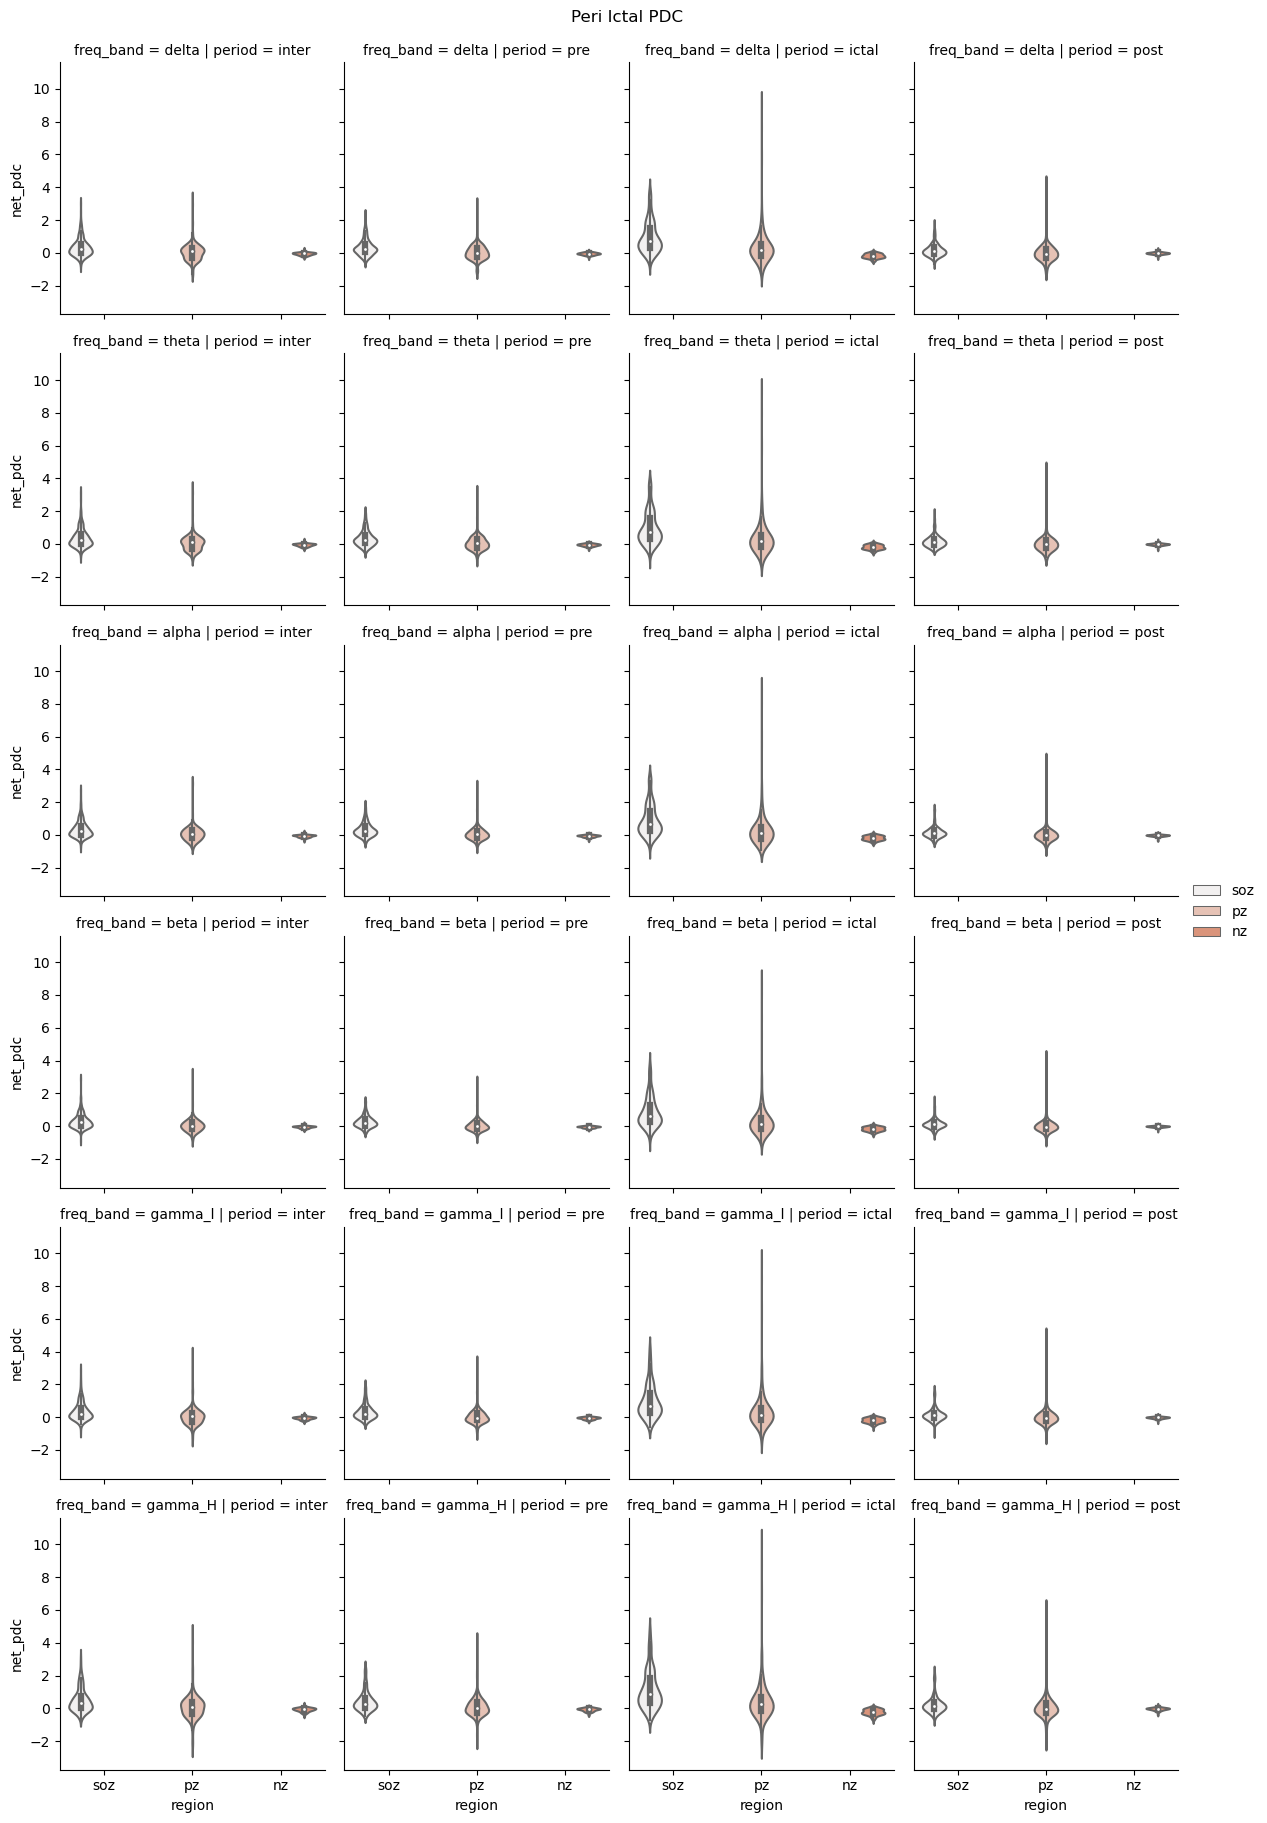

In [93]:
# alpha_peri_df.groupby(['subj','period','region']).mean().reset_index()
with sns.color_palette("flare"):
    grid = sns.FacetGrid(peri_ictal_df,col='period', row='freq_band',col_order=['inter','pre','ictal','post']) 
    grid.map_dataframe(sns.violinplot, y='net_pdc',x='region', positions=[1,2,3], hue='region')
    grid.add_legend()
    grid.figure.suptitle("Peri Ictal PDC",y=1.01)
    plt.savefig("../viz/peri_ictal_pdc.pdf",transparent=True)


## ISH OG Cohort

In [27]:
og_ISH = load_mat('/mnt/ernie_main/PCA_project/data/original_81_structs/PDC_pats.mat')

ish_subj_df = pd.read_csv('../data/ish_subid.csv',header=None)
ish_subj_df.columns = ['og_id']

In [28]:
ish_subj_df['subj_id'] = ish_subj_df.og_id.apply(lambda x : x.split("_")[0])
common_ids = set(ish_subj_df.subj_id).intersection(sub_ids)
len(common_ids) == len(sub_ids) 
#Sanity check to make sure that I have all the
#peri ictal cohort in the ISH cohort. Should be True

True

array(['SOZ', 'SOZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'SOZ', 'SOZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'PZ', 'PZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'SOZ', 'SOZ',
       'SOZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'SOZ', 'SOZ',
       'SOZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'SOZ', 'SOZ', 'SOZ', 'SOZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'SOZ', 'SOZ', 'SOZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ'], dtype='<U3')

In [226]:

epat_26_f = '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat26/Epat26_3_FIAS_imcoh.mat'
epat_26_obj = load_mat(epat_26_f)

pat_df = label_df[label_df.subj == 'Epat26']
regions = get_regions(pat_df, epat_26_obj,'Epat26')

##IF this is true then there is no issue in my designations of SOZ PZ
np.where(regions == epat_26_labels)[0].shape[0] == regions.shape[0]

In [29]:
ish_conn_df = struct_to_pat_df(og_ISH, ish_subj_df.subj_id)

Subj Epat27 has no PZ designation
Subj Epat05 has no PZ designation
Subj Epat11 has no PZ designation


/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivi

Subj Epat22 has no PZ designation
Subj pat33 has no PZ designation
Subj Spat32 has no PZ designation
Subj Spat53 has no PZ designation


/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:123: RuntimeWarning: Mean of empty slice
  net_soz = np.nanmean(soz_in) - np.nanmean(soz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connect

Subj Spat27 has no PZ designation
Subj Epat41 has no PZ designation


/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivi

In [30]:
ish_conn_df

,subj,period,region,net_pdc,freq_band
0,Epat26,eyes_closed_inter,soz,0.910428,theta
1,Epat26,eyes_closed_inter,pz,-0.142375,theta
2,Epat26,eyes_closed_inter,nz,-0.180864,theta
3,Epat26,eyes_closed_inter,soz,0.907172,alpha
4,Epat26,eyes_closed_inter,pz,0.081661,alpha
...,...,...,...,...,...
10,Epat41,eyes_closed_inter,pz,NaN,gamma_l
11,Epat41,eyes_closed_inter,nz,-0.035532,gamma_l
12,Epat41,eyes_closed_inter,soz,0.275541,gamma_H
13,Epat41,eyes_closed_inter,pz,NaN,gamma_H


In [31]:
peri_subj = set(peri_ictal_df.subj)
ish_subj = set(ish_conn_df.subj)

## Flow Between States

In [101]:
tst_subj = sub_ids[0]
tst_folder = folders[0]
tst_files = glob.glob(os.path.join(tst_folder, '*mat'))
tst_label_df = label_df[label_df.subj == tst_subj]

In [102]:
tst_label_df

,subj,bipole,label,contact
4070,Epat02,LH1-LH2,IZ,LH1
4071,Epat02,LH2-LH3,IZ,LH2
4072,Epat02,LH3-LH4,NIZ,LH3
4073,Epat02,LH6-LH7,NIZ,LH6
4074,Epat02,LH7-LH8,NIZ,LH7
...,...,...,...,...
4134,Epat02,ROF4-ROF5,PZ,ROF5
4135,Epat02,ROF5-ROF6,PZ,ROF6
4136,Epat02,ROF6-ROF7,PZ,ROF7
4137,Epat02,ROF8-ROF9,NIZ,ROF9


In [108]:
tst_flow_df = map_subject_to_flow(tst_subj, tst_files, tst_label_df, filt_dist=20)

In [109]:
tst_flow_df

,source,target,value,subj,band,period
0,soz,soz,0.000000,Epat02,delta,inter
1,soz,pz,0.767282,Epat02,delta,inter
2,soz,nz,1.053783,Epat02,delta,inter
3,pz,soz,0.757451,Epat02,delta,inter
4,pz,pz,4.002173,Epat02,delta,inter
...,...,...,...,...,...,...
4,pz,pz,3.807948,Epat02,gamma_H,post
5,pz,nz,17.851816,Epat02,gamma_H,post
6,nz,soz,2.924077,Epat02,gamma_H,post
7,nz,pz,13.468525,Epat02,gamma_H,post
